In [1]:
#+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
# Script to run and export ISSM relaxation
# Mikayla Pascual 07/13/22
#+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

#import 
from MatlabFuncs import *
from model import *
from triangle import *
from bamg import bamg
from savevars import *
import plotdoc
from loadmodel import *
from os.path import exists

from scipy.io import loadmat
from m1qn3inversion import *
import numpy as np
from ContourToNodes import *
from solve import *

#import lhsmdu #install in terminal 'pip install lhsmdu'
import matplotlib.pyplot as plt
import pickle

import numpy as np
from osgeo import gdal
from matplotlib import pyplot as plt

from InterpFromGridToMesh import InterpFromGridToMesh
from InterpFromMeshToMesh2d import InterpFromMeshToMesh2d

In [2]:
region = 'SAtoES'
start_year = 1985.

Opening ./Models/SAtoES_inversion.nc for reading 
empty init
solutionstep


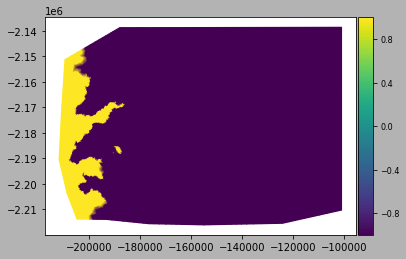

In [3]:
md = loadmodel('./Models/SAtoES_inversion.nc')
md.levelset.spclevelset = np.nan * np.ones((md.mesh.numberofvertices))
pos = md.mesh.vertexonboundary == 1
#pos = np.where(md.mesh.vertexonboundary)
md.levelset.spclevelset[pos] = md.mask.ice_levelset[pos]
md.levelset.migration_max = 1e10
plotmodel(md, 'data', md.mask.ice_levelset)

In [4]:
## Relaxation
#Put results of inversion back into the model for forward runs
md.friction.coefficient=md.results.StressbalanceSolution.FrictionCoefficient
relaxation_years = 1 #try 5 years if 1 runs quickly

# Special post-processing of inverted friction coefficient
filename = 'Exp/' +region+ '_coeffront_after_inversion.exp'
if os.path.isfile(filename):
  pos = find(ContourToNodes(md.mesh.x, md.mesh.y, filename, 1))
  md.friction.coefficient[pos] = 10

md.initialization.pressure = np.zeros([md.mesh.numberofvertices,1])
md.initialization.temperature = 250*np.ones([md.mesh.numberofvertices,1]) #temperature is in kelvin

# Set parameters
md.inversion.iscontrol=0;
md.timestepping.start_time = start_year;
md.timestepping.time_step  = .02;
md.timestepping.final_time = start_year + relaxation_years;
md.settings.output_frequency = (1/md.timestepping.time_step)/5; # 5/yr

In [5]:
#with open('ens_dict.pickle', 'rb') as f:
    #ens_data = pickle.load(f)

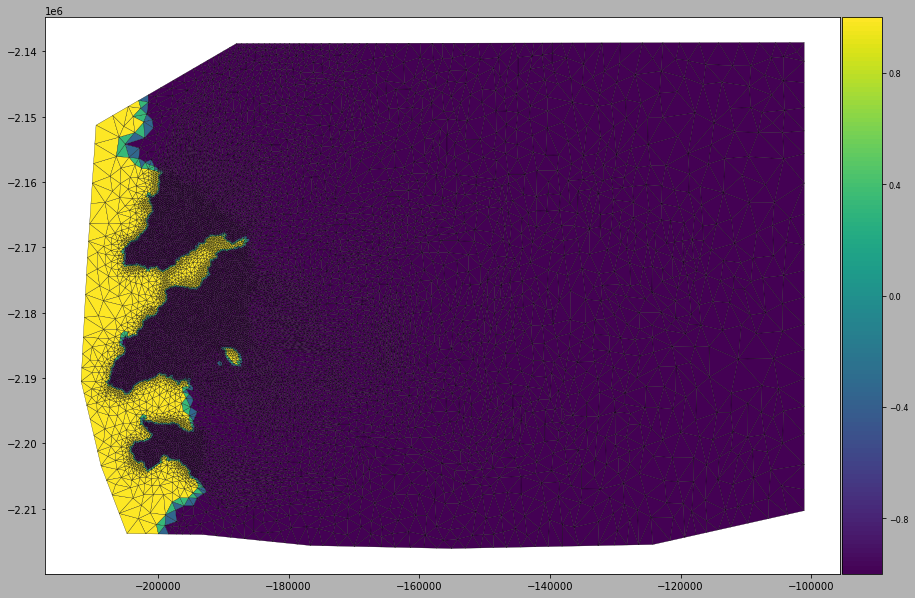

In [6]:
fig = plt.figure(figsize=(15,15))
plotmodel(md, 'data', md.mask.ice_levelset, 'edgecolor', 'k')

#plt.xlim(-215000, -190000)
#plt.ylim(-2210000, -2170000)

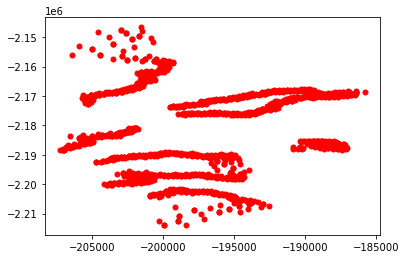

In [7]:
# define fjord walls/flush where bed > 0 (code added 8/3/22)
n_buffer = 2
for i in range(n_buffer):
    elements = md.mesh.elements.astype(int)-1
    nodes_edge = elements[np.where(np.sum(md.mask.ice_levelset[elements] == -1, axis=1) == 2)[0]]
    nodes_edge = np.unique(nodes_edge.ravel())
    nodes_bed = np.where(md.geometry.bed > 0)[0]
    nodes_edge_bed = np.array(list(set(nodes_edge) & set(nodes_bed)))
    plt.plot(md.mesh.x[nodes_edge_bed], md.mesh.y[nodes_edge_bed], 'r.', markersize=10)

    md.mask.ice_levelset[nodes_edge_bed] = -1
    md.geometry.thickness[nodes_edge_bed] = 10
    md.geometry.surface[nodes_edge_bed] = md.geometry.bed[nodes_edge_bed] + md.geometry.thickness[nodes_edge_bed]

    md.friction.coefficient[nodes_edge_bed] = 200

In [8]:
# defining thermal and sub. discharge at every ISSM mesh node 

# load raster of basins
ds = gdal.Open('./Cheat_matfiles/tidewaterbasins_rignotid.mat_tidewaterbasins.tif', gdal.GA_ReadOnly)
rb = ds.GetRasterBand(1)
basins_array = rb.ReadAsArray()

gt = ds.GetGeoTransform()
ulx, xres, xskew, uly, yskew, yres  = gt
lrx = ulx + (ds.RasterXSize * xres)
lry = uly + (ds.RasterYSize * yres)
x = np.arange(ulx, lrx,  xres)
y = np.arange(lry, uly, -yres)

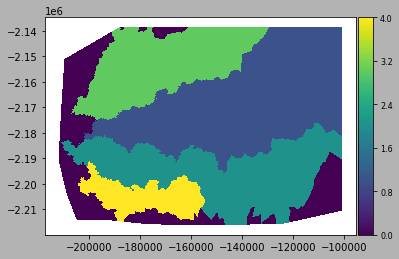

In [9]:
# interpolate basin to each mesh node 
px = np.array( ((md.mesh.x - gt[0]) / gt[1]).astype(int) )
py = np.array( ((md.mesh.y - gt[3]) / gt[5]).astype(int) )

basins_mesh = basins_array[py.astype(int), px.astype(int)]

# ISSM wants basins to be numbered from 1 to 4 with the basins that we don't care about numbered 0
basins_mesh[basins_mesh==13] = 1
basins_mesh[basins_mesh==52] = 2
basins_mesh[basins_mesh==53] = 3
basins_mesh[basins_mesh==90] = 4
basins_mesh[(basins_mesh<1) | (basins_mesh>4)] = 0

# find basin id for each element
basins_elements = basins_mesh[md.mesh.elements-1]
basins_elements = np.max(basins_elements, axis=1)

plotmodel(md, 'data', basins_elements)

In [10]:
# Assigning ocean thermal (EN4) and subglacial discharge (RACMO2.3p2) forcings
from scipy_io_utils import *

# Load historical forcing data
glacier_list = list()
m = loadmat('./Cheat_matfiles/glacier0013.mat')
glacier0013 = m['glacier0013']
m = loadmat('./Cheat_matfiles/glacier0052.mat')
glacier0052 = m['glacier0052']
m = loadmat('./Cheat_matfiles/glacier0053.mat')
glacier0053 = m['glacier0053']
m = loadmat('./Cheat_matfiles/glacier0090.mat')
glacier0090 = m['glacier0090']

# Thermal forcing
t = glacier0013['EN4']['t']
TF = glacier0013['EN4']['TF']

# Discharge
t = glacier0013['RACMO']['Q']
Q = glacier0013['RACMO']['Q']

from frontalforcingsrignot import frontalforcingsrignot
md.frontalforcings = frontalforcingsrignot()
valid = ~np.isnan(glacier0013['EN4']['TF'])
md.frontalforcings.thermalforcing = np.zeros( (md.mesh.numberofvertices+1, len(glacier0013['EN4']['TF'][valid])) )
md.frontalforcings.subglacial_discharge = np.zeros( (md.mesh.numberofvertices+1, len(glacier0013['RACMO']['Q'])) )

In [11]:
# Assign forcings to correct node 

# step 1: find which nodes belong to each basin using basin_mesh
get_indexes = lambda basins_mesh, xs: [i for (y, i) in zip(xs, range(len(xs))) if basins_mesh == y]
glacier13_nodes = get_indexes(1,basins_mesh)
glacier52_nodes = get_indexes(2,basins_mesh)
glacier53_nodes = get_indexes(3,basins_mesh)
glacier90_nodes = get_indexes(4,basins_mesh)

# NOTE: Denis combined steps 2 and 3: we select the rows and set to the TF time series
# step 2: select() rows from frontalforcings.thermal that correspond to step 1 nodes
md.frontalforcings.thermalforcing[glacier13_nodes,:] = glacier0013['EN4']['TF'][valid]
md.frontalforcings.thermalforcing[glacier52_nodes,:] = glacier0052['EN4']['TF'][valid]
md.frontalforcings.thermalforcing[glacier53_nodes,:] = glacier0053['EN4']['TF'][valid]
md.frontalforcings.thermalforcing[glacier90_nodes,:] = glacier0090['EN4']['TF'][valid]

# step 2: select() rows from frontalforcings.subglacial_discharge that correspond to step 1 nodes
md.frontalforcings.subglacial_discharge[glacier13_nodes,:] = glacier0013['RACMO']['Q'] * 86400
md.frontalforcings.subglacial_discharge[glacier52_nodes,:] = glacier0052['RACMO']['Q'] * 86400
md.frontalforcings.subglacial_discharge[glacier53_nodes,:] = glacier0053['RACMO']['Q'] * 86400
md.frontalforcings.subglacial_discharge[glacier90_nodes,:] = glacier0090['RACMO']['Q'] * 86400

# NOTE: And now, set the last row to the time
md.frontalforcings.thermalforcing[-1,:] = glacier0013['EN4']['t'][valid]
md.frontalforcings.subglacial_discharge[-1,:] = glacier0013['RACMO']['t']

# NOTE: All times are the same for the TF time series for each glacier so we just set the times equal to the glacier0013 times


In [12]:
print(np.where(np.isnan(md.frontalforcings.subglacial_discharge)))
print(np.where(np.isinf(md.frontalforcings.subglacial_discharge)))
print(np.where(np.isnan(md.frontalforcings.thermalforcing)))
print(np.where(np.isinf(md.frontalforcings.thermalforcing)))
print(np.where(np.isnan(md.geometry.bed)))
print(np.where(np.isinf(md.geometry.bed)))

(array([], dtype=int64), array([], dtype=int64))
(array([], dtype=int64), array([], dtype=int64))
(array([], dtype=int64), array([], dtype=int64))
(array([], dtype=int64), array([], dtype=int64))
(array([], dtype=int64),)
(array([], dtype=int64),)


In [ ]:
#for ensemble_ID in ens_data.keys():
# set up to run all 10 in one run
#ensemble_ID = 'Trial9' # change ID for each Trial value
#subglacial_discharge = ens_data[ensemble_ID]['sd_after']
#thermal_forcing = ens_data[ensemble_ID]['tf_after']
#calving = ens_data[ensemble_ID]['calve_after']

#print(ensemble_ID)
#print(subglacial_discharge)
#print(thermal_forcing)
#print(calving)
#continue

# We set the transient parameters
md.transient.ismovingfront=1
md.transient.isthermal=0
md.transient.isstressbalance=1
md.transient.ismasstransport=1
md.transient.isgroundingline=1
md.groundingline.migration = 'SubelementMigration'

# We set the ocean conditions
#from frontalforcingsrignot import frontalforcingsrignot
#md.frontalforcings = frontalforcingsrignot()

#+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
#md.frontalforcings.subglacial_discharge = 0.0026 * np.ones(md.mesh.numberofvertices) + 0.05003857059290104 #add LHS value
#md.frontalforcings.thermalforcing = 15.7 * np.ones(md.mesh.numberofvertices) + -2.0840162904433726 #add LHS value

pos = np.where(md.geometry.bed > 0)[0]
md.frontalforcings.subglacial_discharge[pos] = 0
md.frontalforcings.thermalforcing[pos] = 0
#+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

md.frontalforcings.basin_id = basins_elements
md.frontalforcings.num_basins = 4

# We set the calving model (no moving front ... spclevelset is actually ignored)
from calvingvonmises import calvingvonmises
md.calving = calvingvonmises()

#+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
md.calving.stress_threshold_groundedice = 1000000.0 #replace with LHS value
#+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

#md.levelset.spclevelset = np.nan * np.ones([md.mesh.numberofvertices,1])
#md.calving.calvingrate = np.zeros([md.mesh.numberofvertices,1])
#md.frontalforcings.meltingrate = np.zeros([md.mesh.numberofvertices,1])
#md.calving.meltingrate = np.ones([md.mesh.numberofvertices,1])

# Set the requested outputs
md.stressbalance.requested_outputs=['default']
md.transient.requested_outputs=['default','IceVolumeAboveFloatation','BasalforcingsGroundediceMeltingRate','CalvingMeltingrate']

# Go solve
md.verbose.solution=1
from socket import gethostname
from generic import generic
md.cluster = generic('name', gethostname(), 'np', 16)
md.settings.waitonlock = np.inf
md.cluster.interactive = 0

from solve import solve
md = solve(md, 'tr')

from export_netCDF import export_netCDF

md.inversion.cost_functions = md.inversion.cost_functions.astype(np.float64)
for i in range(len(md.results.TransientSolution)):
    md.results.TransientSolution[i].step = np.float64(md.results.TransientSolution[i].step)

#export_netCDF(md, "./Models/SAtoES_relaxation_" +ensemble_ID+ ".nc")
#export_netCDF(md, "./Models/SAtoES_relaxation_control.nc")

checking model consistency
marshalling file SAtoES.bin
uploading input file and queueing script
launching solution sequence on remote cluster


In [ ]:
#md = loadmodel('./Models/SAtoES_relaxation_Trial9.nc')
md = loadmodel('./Models/SAtoES_relaxation_control.nc')

In [ ]:
md.timestepping.final_time = 1995.
md = solve(md, 'tr')

checking model consistency
marshalling file SAtoES.bin
uploading input file and queueing script
launching solution sequence on remote cluster


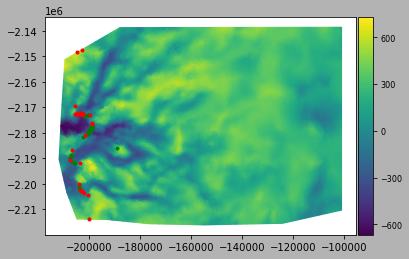

In [18]:
time = [md.results.TransientSolution[i].time for i in range(len(md.results.TransientSolution))]
VAF = [md.results.TransientSolution[i].IceVolumeAboveFloatation for i in range(len(md.results.TransientSolution))]

# Look for terminus advance
idx = np.logical_and(np.array(md.mask.ice_levelset) > 0, \
                     np.array(md.results.TransientSolution[-1].MaskIceLevelset).ravel() <= 0)
pos_advance = np.where(idx)[0]

# Look for terminus retreat
idx = np.logical_and(np.array(md.mask.ice_levelset) < 0, \
                     np.array(md.results.TransientSolution[-1].MaskIceLevelset).ravel() >= 0)
pos_retreat = np.where(idx)[0]

#fig = plt.figure(figsize=(10,10))
#plotmodel(md, 'data', np.array(md.mask.ice_levelset), \
#              'data', np.array(md.results.TransientSolution[5].MaskIceLevelset).ravel(), \
#              'caxis#all', [-1., +1.])
#plotmodel(md, 'data', np.array(md.mask.ice_levelset) - np.array(md.results.TransientSolution[-1].MaskIceLevelset).ravel(), \
#              'caxis#all', [-1, +1])

plotmodel(md, 'data', md.mask.ice_levelset)
plt.plot(md.mesh.x[pos_advance], md.mesh.y[pos_advance], 'g.')
plt.plot(md.mesh.x[pos_retreat], md.mesh.y[pos_retreat], 'r.')